# Introduction
## Task
The task is to solve multiclass classification problem and predict type of car on an image.

Following approaches were tested:

1. Building CNN without pretrained model (not even in this notebook due to very bad perfomance, wich is caused by size of the dataset and strong similarity of certain classes (e.g. family sedan & minibas, heavy truck & fire engine))
2. Building CNN with ConvMixer blocks (kicked as well)
3. Transfer learning based on frozen InceptionV3 model
4. Fine-tuning InceptionV3 model (best result)

IncptionV3 was chosen based on the article [1], according to it, InceptionV3 has a little bit higher accuracy than VGGs, ResNet50V2 and MobileNetV2 for car type classification task. During work on this notebook was noticed unusual (for me) behavior of Loss and Accuracy plots. Validation accuracy is much higher than train accuracy, also, validation loss is lower than train loss. The reason of such behavior was revealed, and it is caused by using dropout and regularization. The point is, when using regularization, train loss is calculated as sum of train set prediction error and regularization penalty, while validation loss is just validation set prediction error: [2, 3]

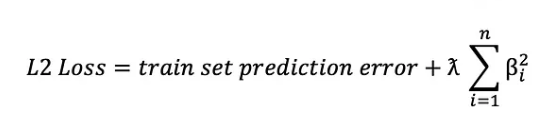

At the same time lower training accuracy is caused by dropout. Since it is applied only when training the model, it marks down training accuracy [4]

Feel free to fork or edit the notebook. If you have any feedback or improvement on this approach do share in comments. Thank you.

## References
https://mlbhanuyerra.github.io/2019-10-31-ClassifyingCarImagesByVehileType/

https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import applications
import os

In [2]:
BATCH_SIZE = 64
IMG_HEIGHT = 150
IMG_WIDTH = 150
SEED=31

In [3]:
train_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//vehicle_classification//data//train'
val_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//vehicle_classification//data//val'
test_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//vehicle_classification//data//test' #not used here
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=(BATCH_SIZE)
)
labeled_test_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 1400 files belonging to 10 classes.
Using 1120 files for training.
Found 200 files belonging to 10 classes.
Found 1400 files belonging to 10 classes.
Using 280 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['SUV',
 'bus',
 'family sedan',
 'fire engine',
 'heavy truck',
 'jeep',
 'minibus',
 'racing car',
 'taxi',
 'truck']

In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 150, 150, 3)
(64, 10)


In [6]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 150, 150, 3)
(64, 10)


In [7]:
for image_batch, labels_batch in labeled_test_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 150, 150, 3)
(64, 10)


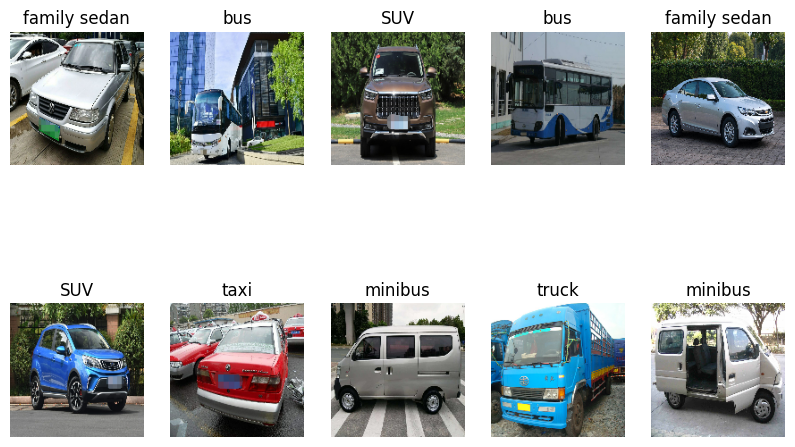

In [8]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        ax = plt.subplot(10 // 5 + 1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.argmax(labels[i])])
        plt.axis("off")

In [9]:
# Count the number of objects in each class for dataset splits
class_counts_train = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_index = label.argmax()  # Get the class index with the highest probability
        if class_index not in class_counts_train:
            class_counts_train[class_index] = 0
        class_counts_train[class_index] += 1


class_counts_validation = {}
for images, labels in val_ds:
    for label in labels.numpy():
        class_index = label.argmax()
        if class_index not in class_counts_validation:
            class_counts_validation[class_index] = 0
        class_counts_validation[class_index] += 1
      
    
class_counts_labeled_test = {}
for images, labels in labeled_test_ds:
    for label in labels.numpy():
        class_index = label.argmax()
        if class_index not in class_counts_labeled_test:
            class_counts_labeled_test[class_index] = 0
        class_counts_labeled_test[class_index] += 1


print("Training Dataset Class Counts:")
print(class_counts_train)

print("Validation Dataset Class Counts:")
print(class_counts_validation)

print("Test Dataset Class Counts:")
print(class_counts_labeled_test)

Training Dataset Class Counts:
{0: 114, 7: 114, 1: 115, 9: 118, 5: 106, 3: 116, 8: 113, 6: 107, 4: 105, 2: 112}
Validation Dataset Class Counts:
{6: 20, 5: 20, 7: 20, 1: 20, 0: 20, 8: 20, 9: 20, 3: 20, 4: 20, 2: 20}
Test Dataset Class Counts:
{8: 27, 5: 34, 7: 26, 6: 33, 3: 24, 0: 26, 1: 25, 9: 22, 2: 28, 4: 35}


In [10]:
# autotune datasets (or it`ll be a bottleneck)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
labeled_test_ds = labeled_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [14]:
class TransferModel:
    def __init__(self,
                 shape: tuple,
                 trainable=False,
                 dense_layer_neurons=8,
                 alpha=0.001,
                 dropout_rate=0.5):
        """
        Class for transfer learning based on InceptionV3
        
        Args:
            shape: Input shape as tuple (height, width, channels)
            trainable: Boolean, trainable or frozen base model (False by default)
            dense_layer_neurons: Int amount of neurons in dense layer (8 by default)
            alpha: Float, parameter alpha for L2 regularization
            dropout_rate: Float, probability of dropout for neurons in dense layer
        """
        self.shape = shape
        self.trainable = trainable
        self.dense_layer_neurons = dense_layer_neurons
        self.alpha = alpha
        self.dropout_rate = dropout_rate
        self.class_names = class_names
        
        # load inception model
        self.base_model = applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(shape=self.shape)
        )

        # set trainable param
        self.base_model.trainable = self.trainable

        # create inputs and perform necessary preprocessing
        inputs = Input(shape=self.shape)
        inception_preprocess = tf.keras.applications.inception_v3.preprocess_input (inputs)

        x = self.base_model (inception_preprocess)

        # create top layers
        x = Flatten() (x)
        x = Dense(self.dense_layer_neurons, activation = "relu", kernel_regularizer=l2(self.alpha)) (x)
        x = BatchNormalization() (x)
        x = Dropout(self.dropout_rate) (x)
        outputs = Dense(10, activation='softmax') (x)

        self.model = Model(inputs=inputs, outputs=outputs)
        
    def compile_model(self, **kwargs):
        """
        Pass args to default compile method
        """
        self.model.compile(**kwargs)
        
    def fit(self, 
            train_ds, 
            val_ds, 
            epochs=1000,
            use_callbacks=True, 
            checkpoint_dir='checkpoints',
            patience=10,
            verbose=1,
            **kwargs):
        """
        Train model and create callbacks
        
        Args:
            train_ds: training dataset (e.g. BatchDataset)
            val_ds: validation dataset (e.g. BatchDataset)
            epochs: Int, amount of epochs to train model
            use_callbacks: Boolean, use callbacks or nor (True by default)
            checkpoint_dir: String, specify directory to store checkpoints
                            not necessary if use_callback=False ('checkpoints' by default)
            patience: Int, set patience parameter for early_stopping callback
                            not necessary if use_callback=False (10 by default)
            verbose: Int, print info or not (1 by default)
            
        Returns:
            Training history from self.history
        """
        
        # check if using callbacks
        if use_callbacks:
            # create checkpoint_dir id it doesn`t exist
            if not os.path.isdir(checkpoint_dir):
                os.mkdir(checkpoint_dir)
                
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.0001,
                patience=patience,
                verbose=verbose,
                mode="auto",
                restore_best_weights=True)
            
            filepath = checkpoint_dir+'/model_{epoch:02d}-{val_loss:.2f}.h5'
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=filepath,
                monitor="val_loss",
                verbose=verbose,
                save_best_only=True,
                save_weights_only=True,
                mode="auto",
                save_freq="epoch",
                initial_value_threshold=1.)
            
            callbacks = [checkpoint, early_stopping]
            
        else: 
            callbacks = None
            
        self.history = self.model.fit(train_ds,
                                      callbacks=callbacks,
                                      validation_data=val_ds,
                                      epochs=epochs,
                                      **kwargs)
        return self.history
    
    def evaluate(self, test_ds):
        """
        Evaluate trained model
        
        Args:
            test_ds: test dataset with labels (e.g. BatchDataset)
            
        Returns:
            y_true: True labels for test objects
            y_pred: Predicted labels for test objects
        """
        y_pred = np.argmax(self.model.predict(test_ds), axis=-1)

        y_pred = []
        y_true = np.array([])
        for image, label in test_ds:
            y_pred = np.concatenate([y_pred, np.argmax(self.model.predict(image), axis=-1)])
            y_true = np.concatenate([y_true, np.argmax(label.numpy(), axis=-1)])
        return y_true, y_pred

# Inception V3 (not trainable)

In [45]:
not_trainable_model = TransferModel(shape=(IMG_HEIGHT,IMG_WIDTH,3),
                                    trainable=False,
                                    dense_layer_neurons=8,
                                    alpha=0.001,
                                    dropout_rate=0.5)

In [46]:
not_trainable_model.compile_model(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0003),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

In [47]:
not_trainable_model.model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dense_8 (Dense)             (None, 8)                 1474

In [48]:
not_trainable_history = not_trainable_model.fit(train_ds=train_ds, 
                                                val_ds=val_ds, 
                                                epochs=1000,
                                                use_callbacks=True, 
                                                checkpoint_dir='checkpoints_not_trainable',
                                                patience=20,
                                                verbose=1)

Epoch 1/1000
17/18 [===========================>..] - ETA: 0s - loss: 2.1782 - accuracy: 0.2282
Epoch 1: val_loss did not improve from 1.00000
18/18 [==============================] - 4s 84ms/step - loss: 2.1663 - accuracy: 0.2330 - val_loss: 2.2469 - val_accuracy: 0.3450
Epoch 2/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.8919 - accuracy: 0.3002
Epoch 2: val_loss did not improve from 1.00000
18/18 [==============================] - 1s 45ms/step - loss: 1.8884 - accuracy: 0.2964 - val_loss: 1.7286 - val_accuracy: 0.3900
Epoch 3/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.8130 - accuracy: 0.3068
Epoch 3: val_loss did not improve from 1.00000
18/18 [==============================] - 1s 44ms/step - loss: 1.8115 - accuracy: 0.3080 - val_loss: 1.5685 - val_accuracy: 0.4550
Epoch 4/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.7638 - accuracy: 0.3428
Epoch 4: val_loss did not improve from 1.00000
18/18 [==============================]

Epoch 31/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.1861 - accuracy: 0.5862
Epoch 31: val_loss did not improve from 1.00000
18/18 [==============================] - 1s 38ms/step - loss: 1.1802 - accuracy: 0.5920 - val_loss: 1.1834 - val_accuracy: 0.7150
Epoch 32/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.1856 - accuracy: 0.5882
Epoch 32: val_loss did not improve from 1.00000
18/18 [==============================] - 1s 38ms/step - loss: 1.1850 - accuracy: 0.5875 - val_loss: 1.1991 - val_accuracy: 0.7550
Epoch 33/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.1769 - accuracy: 0.5843
Epoch 33: val_loss did not improve from 1.00000
18/18 [==============================] - 1s 42ms/step - loss: 1.1783 - accuracy: 0.5813 - val_loss: 1.1114 - val_accuracy: 0.7850
Epoch 34/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.1902 - accuracy: 0.5824
Epoch 34: val_loss did not improve from 1.00000
18/18 [=======================

Epoch 60/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.0608 - accuracy: 0.5919
Epoch 60: val_loss did not improve from 0.90525
18/18 [==============================] - 1s 38ms/step - loss: 1.0622 - accuracy: 0.5902 - val_loss: 0.9166 - val_accuracy: 0.8000
Epoch 61/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.0535 - accuracy: 0.6023
Epoch 61: val_loss did not improve from 0.90525
18/18 [==============================] - 1s 38ms/step - loss: 1.0622 - accuracy: 0.5929 - val_loss: 0.9137 - val_accuracy: 0.7800
Epoch 62/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9906 - accuracy: 0.6392
Epoch 62: val_loss did not improve from 0.90525
18/18 [==============================] - 1s 39ms/step - loss: 0.9909 - accuracy: 0.6366 - val_loss: 0.9255 - val_accuracy: 0.8350
Epoch 63/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9987 - accuracy: 0.6458
Epoch 63: val_loss did not improve from 0.90525
18/18 [=======================

18/18 [==============================] - 1s 53ms/step - loss: 0.9251 - accuracy: 0.6473 - val_loss: 0.7645 - val_accuracy: 0.8250
Epoch 89/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9146 - accuracy: 0.6480
Epoch 89: val_loss did not improve from 0.76449
18/18 [==============================] - 1s 38ms/step - loss: 0.9123 - accuracy: 0.6482 - val_loss: 0.7896 - val_accuracy: 0.7950
Epoch 90/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9344 - accuracy: 0.6364
Epoch 90: val_loss did not improve from 0.76449
18/18 [==============================] - 1s 39ms/step - loss: 0.9360 - accuracy: 0.6384 - val_loss: 0.7947 - val_accuracy: 0.7950
Epoch 91/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9399 - accuracy: 0.6241
Epoch 91: val_loss did not improve from 0.76449
18/18 [==============================] - 1s 38ms/step - loss: 0.9360 - accuracy: 0.6286 - val_loss: 0.8021 - val_accuracy: 0.7900
Epoch 92/1000
17/18 [========================

17/18 [===========================>..] - ETA: 0s - loss: 0.8477 - accuracy: 0.6487
Epoch 117: val_loss did not improve from 0.68719
18/18 [==============================] - 1s 38ms/step - loss: 0.8466 - accuracy: 0.6509 - val_loss: 0.7151 - val_accuracy: 0.8250
Epoch 118/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8191 - accuracy: 0.6714
Epoch 118: val_loss did not improve from 0.68719
18/18 [==============================] - 1s 38ms/step - loss: 0.8161 - accuracy: 0.6714 - val_loss: 0.6910 - val_accuracy: 0.8350
Epoch 119/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9025 - accuracy: 0.6269
Epoch 119: val_loss did not improve from 0.68719
18/18 [==============================] - 1s 38ms/step - loss: 0.8855 - accuracy: 0.6339 - val_loss: 0.6881 - val_accuracy: 0.8300
Epoch 120/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8118 - accuracy: 0.6705
Epoch 120: val_loss did not improve from 0.68719
18/18 [==============================

18/18 [==============================] - 1s 38ms/step - loss: 0.8148 - accuracy: 0.6687 - val_loss: 0.6215 - val_accuracy: 0.8450
Epoch 145/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8247 - accuracy: 0.6590
Epoch 145: val_loss did not improve from 0.61070
18/18 [==============================] - 1s 38ms/step - loss: 0.8244 - accuracy: 0.6598 - val_loss: 0.6351 - val_accuracy: 0.8300
Epoch 146/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8053 - accuracy: 0.6884
Epoch 146: val_loss did not improve from 0.61070
18/18 [==============================] - 1s 39ms/step - loss: 0.8044 - accuracy: 0.6893 - val_loss: 0.6505 - val_accuracy: 0.8350
Epoch 147/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8171 - accuracy: 0.6638
Epoch 147: val_loss did not improve from 0.61070
18/18 [==============================] - 1s 39ms/step - loss: 0.8139 - accuracy: 0.6661 - val_loss: 0.6208 - val_accuracy: 0.8500
Epoch 148/1000
17/18 [=================

18/18 [==============================] - 1s 38ms/step - loss: 0.8072 - accuracy: 0.6571 - val_loss: 0.6106 - val_accuracy: 0.8400
Epoch 174/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7830 - accuracy: 0.6884
Epoch 174: val_loss did not improve from 0.57832
18/18 [==============================] - 1s 38ms/step - loss: 0.7881 - accuracy: 0.6848 - val_loss: 0.5962 - val_accuracy: 0.8350
Epoch 175/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7488 - accuracy: 0.6960
Epoch 175: val_loss did not improve from 0.57832
18/18 [==============================] - 1s 38ms/step - loss: 0.7568 - accuracy: 0.6902 - val_loss: 0.6067 - val_accuracy: 0.8400
Epoch 176/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7721 - accuracy: 0.6856
Epoch 176: val_loss did not improve from 0.57832
18/18 [==============================] - 1s 38ms/step - loss: 0.7711 - accuracy: 0.6875 - val_loss: 0.6135 - val_accuracy: 0.8350
Epoch 177/1000
17/18 [=================

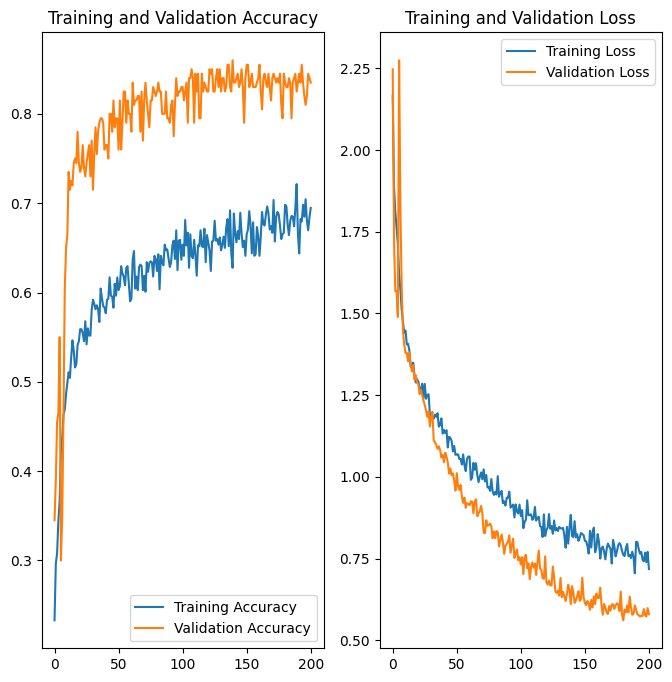

In [49]:
plot_history(not_trainable_history)

In [50]:
y_true, y_pred = not_trainable_model.evaluate(labeled_test_ds)

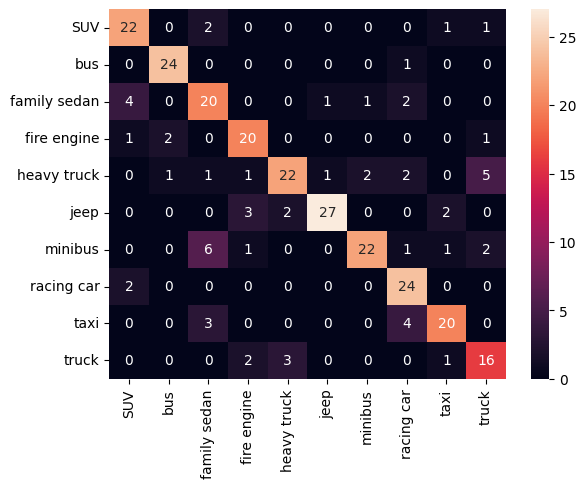

In [51]:
conf = confusion_matrix(y_true, y_pred)
_ = sns.heatmap(conf, annot=True, yticklabels=class_names, xticklabels=class_names)

In [52]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80        26
         1.0       0.89      0.96      0.92        25
         2.0       0.62      0.71      0.67        28
         3.0       0.74      0.83      0.78        24
         4.0       0.81      0.63      0.71        35
         5.0       0.93      0.79      0.86        34
         6.0       0.88      0.67      0.76        33
         7.0       0.71      0.92      0.80        26
         8.0       0.80      0.74      0.77        27
         9.0       0.64      0.73      0.68        22

    accuracy                           0.78       280
   macro avg       0.78      0.78      0.77       280
weighted avg       0.79      0.78      0.77       280



# Inception V3 (trainable)

In [57]:
trainable_model = TransferModel(shape=(IMG_HEIGHT,IMG_WIDTH,3),
                                    trainable=True,
                                    dense_layer_neurons=8,
                                    alpha=0.001,
                                    dropout_rate=0.5)

In [58]:
trainable_model.compile_model(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

In [59]:
trainable_model.model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 18432)             0         
                                                                 
 dense_12 (Dense)            (None, 8)                 1474

In [60]:
trainable_history = trainable_model.fit(train_ds=train_ds, 
                                                val_ds=val_ds, 
                                                epochs=1000,
                                                use_callbacks=True, 
                                                checkpoint_dir='checkpoints_trainable',
                                                patience=10,
                                                verbose=1)

Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 2.4957 - accuracy: 0.1491
Epoch 1: val_loss did not improve from 1.00000
18/18 [==============================] - 6s 146ms/step - loss: 2.4957 - accuracy: 0.1491 - val_loss: 3.8121 - val_accuracy: 0.1400
Epoch 2/1000
18/18 [==============================] - ETA: 0s - loss: 1.9274 - accuracy: 0.3089
Epoch 2: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 104ms/step - loss: 1.9274 - accuracy: 0.3089 - val_loss: 2.6080 - val_accuracy: 0.2700
Epoch 3/1000
18/18 [==============================] - ETA: 0s - loss: 1.6435 - accuracy: 0.4250
Epoch 3: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 105ms/step - loss: 1.6435 - accuracy: 0.4250 - val_loss: 2.3137 - val_accuracy: 0.2550
Epoch 4/1000
18/18 [==============================] - ETA: 0s - loss: 1.4528 - accuracy: 0.4991
Epoch 4: val_loss did not improve from 1.00000
18/18 [============================

Epoch 31/1000
18/18 [==============================] - ETA: 0s - loss: 0.9421 - accuracy: 0.7804
Epoch 31: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 100ms/step - loss: 0.9421 - accuracy: 0.7804 - val_loss: 1.3051 - val_accuracy: 0.7650
Epoch 32/1000
18/18 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.7705
Epoch 32: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 101ms/step - loss: 0.9380 - accuracy: 0.7705 - val_loss: 1.3107 - val_accuracy: 0.7600
Epoch 33/1000
18/18 [==============================] - ETA: 0s - loss: 0.9092 - accuracy: 0.7929
Epoch 33: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 101ms/step - loss: 0.9092 - accuracy: 0.7929 - val_loss: 1.3113 - val_accuracy: 0.7650
Epoch 34/1000
18/18 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.8045
Epoch 34: val_loss did not improve from 1.00000
18/18 [====================

Epoch 61/1000
18/18 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.8000
Epoch 61: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 105ms/step - loss: 0.8219 - accuracy: 0.8000 - val_loss: 1.1041 - val_accuracy: 0.8000
Epoch 62/1000
18/18 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.7955
Epoch 62: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 105ms/step - loss: 0.8137 - accuracy: 0.7955 - val_loss: 1.1000 - val_accuracy: 0.8150
Epoch 63/1000
18/18 [==============================] - ETA: 0s - loss: 0.8481 - accuracy: 0.7884
Epoch 63: val_loss did not improve from 1.00000
18/18 [==============================] - 2s 109ms/step - loss: 0.8481 - accuracy: 0.7884 - val_loss: 1.0865 - val_accuracy: 0.8050
Epoch 64/1000
18/18 [==============================] - ETA: 0s - loss: 0.7822 - accuracy: 0.8170
Epoch 64: val_loss did not improve from 1.00000
18/18 [====================

Epoch 89/1000
18/18 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.8089
Epoch 89: val_loss improved from 0.93413 to 0.92799, saving model to checkpoints_trainable\model_89-0.93.h5
18/18 [==============================] - 2s 114ms/step - loss: 0.7362 - accuracy: 0.8089 - val_loss: 0.9280 - val_accuracy: 0.8650
Epoch 90/1000
18/18 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.8277
Epoch 90: val_loss improved from 0.92799 to 0.92274, saving model to checkpoints_trainable\model_90-0.92.h5
18/18 [==============================] - 2s 116ms/step - loss: 0.7026 - accuracy: 0.8277 - val_loss: 0.9227 - val_accuracy: 0.8650
Epoch 91/1000
18/18 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.8152
Epoch 91: val_loss did not improve from 0.92274
18/18 [==============================] - 2s 101ms/step - loss: 0.7201 - accuracy: 0.8152 - val_loss: 0.9260 - val_accuracy: 0.8550
Epoch 92/1000
18/18 [==============================]

18/18 [==============================] - 2s 115ms/step - loss: 0.6640 - accuracy: 0.8241 - val_loss: 0.7977 - val_accuracy: 0.8550
Epoch 115/1000
18/18 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.8080
Epoch 115: val_loss did not improve from 0.79769
18/18 [==============================] - 2s 101ms/step - loss: 0.6901 - accuracy: 0.8080 - val_loss: 0.7994 - val_accuracy: 0.8550
Epoch 116/1000
18/18 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.8455
Epoch 116: val_loss improved from 0.79769 to 0.79756, saving model to checkpoints_trainable\model_116-0.80.h5
18/18 [==============================] - 2s 116ms/step - loss: 0.6388 - accuracy: 0.8455 - val_loss: 0.7976 - val_accuracy: 0.8600
Epoch 117/1000
18/18 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.8116
Epoch 117: val_loss improved from 0.79756 to 0.78005, saving model to checkpoints_trainable\model_117-0.78.h5
18/18 [==============================] - 2s 

18/18 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.8348
Epoch 140: val_loss did not improve from 0.65082
18/18 [==============================] - 2s 101ms/step - loss: 0.6207 - accuracy: 0.8348 - val_loss: 0.6556 - val_accuracy: 0.8650
Epoch 141/1000
18/18 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.8509
Epoch 141: val_loss improved from 0.65082 to 0.64902, saving model to checkpoints_trainable\model_141-0.65.h5
18/18 [==============================] - 2s 114ms/step - loss: 0.6089 - accuracy: 0.8509 - val_loss: 0.6490 - val_accuracy: 0.8600
Epoch 142/1000
18/18 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.8420
Epoch 142: val_loss improved from 0.64902 to 0.63582, saving model to checkpoints_trainable\model_142-0.64.h5
18/18 [==============================] - 2s 115ms/step - loss: 0.5954 - accuracy: 0.8420 - val_loss: 0.6358 - val_accuracy: 0.8800
Epoch 143/1000
18/18 [==============================] - ETA

Epoch 192/1000
18/18 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.8348
Epoch 192: val_loss did not improve from 0.48020
18/18 [==============================] - 2s 101ms/step - loss: 0.5335 - accuracy: 0.8348 - val_loss: 0.4837 - val_accuracy: 0.9050
Epoch 193/1000
18/18 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8411
Epoch 193: val_loss did not improve from 0.48020
18/18 [==============================] - 2s 101ms/step - loss: 0.5163 - accuracy: 0.8411 - val_loss: 0.4840 - val_accuracy: 0.9000
Epoch 194/1000
18/18 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.8375
Epoch 194: val_loss did not improve from 0.48020
18/18 [==============================] - 2s 103ms/step - loss: 0.5257 - accuracy: 0.8375 - val_loss: 0.4848 - val_accuracy: 0.8900
Epoch 195/1000
18/18 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.8438
Epoch 195: val_loss did not improve from 0.48020
18/18 [============

Epoch 220/1000
18/18 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.8375
Epoch 220: val_loss improved from 0.43347 to 0.42922, saving model to checkpoints_trainable\model_220-0.43.h5
18/18 [==============================] - 2s 115ms/step - loss: 0.5093 - accuracy: 0.8375 - val_loss: 0.4292 - val_accuracy: 0.9000
Epoch 221/1000
18/18 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8634
Epoch 221: val_loss did not improve from 0.42922
18/18 [==============================] - 2s 101ms/step - loss: 0.4778 - accuracy: 0.8634 - val_loss: 0.4329 - val_accuracy: 0.8800
Epoch 222/1000
18/18 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.8545
Epoch 222: val_loss did not improve from 0.42922
18/18 [==============================] - 2s 101ms/step - loss: 0.4643 - accuracy: 0.8545 - val_loss: 0.4386 - val_accuracy: 0.8850
Epoch 223/1000
18/18 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.8705
Epoch 2

Epoch 248/1000
18/18 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8723
Epoch 248: val_loss did not improve from 0.38128
18/18 [==============================] - 2s 101ms/step - loss: 0.4445 - accuracy: 0.8723 - val_loss: 0.4038 - val_accuracy: 0.9050
Epoch 249/1000
18/18 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8607
Epoch 249: val_loss did not improve from 0.38128
Restoring model weights from the end of the best epoch: 239.
18/18 [==============================] - 2s 106ms/step - loss: 0.4637 - accuracy: 0.8607 - val_loss: 0.3981 - val_accuracy: 0.9150
Epoch 249: early stopping


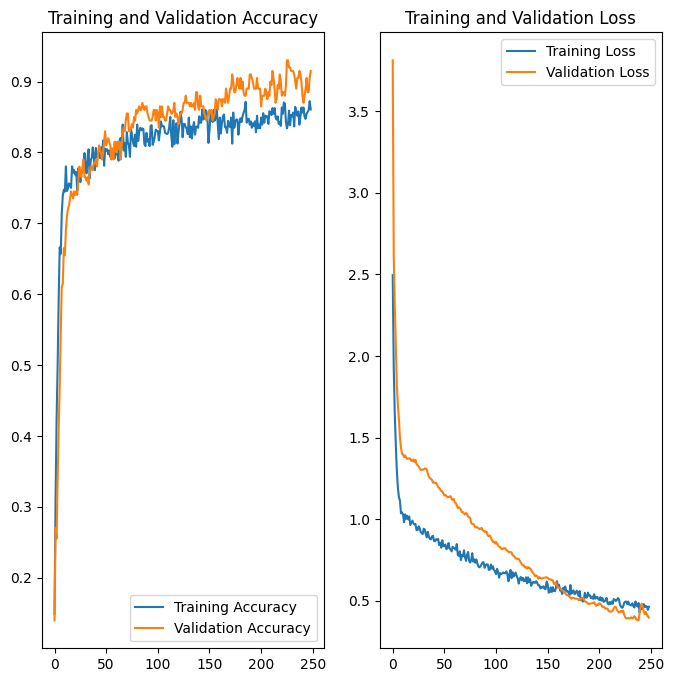

In [61]:
plot_history(trainable_history)

In [63]:
y_true, y_pred = trainable_model.evaluate(labeled_test_ds)

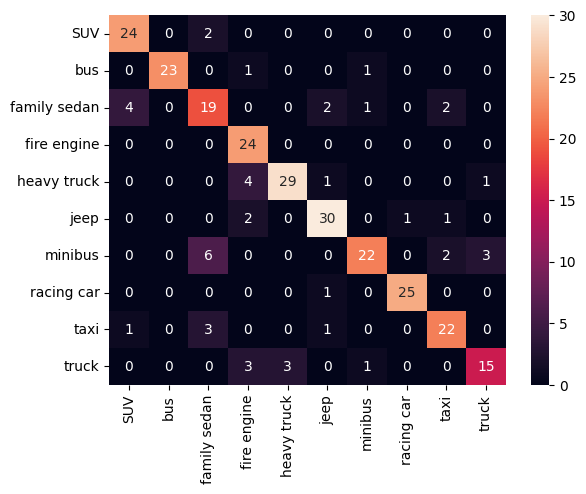

In [64]:
conf = confusion_matrix(y_true, y_pred)
_ = sns.heatmap(conf, annot=True, yticklabels=class_names, xticklabels=class_names)

In [65]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87        26
         1.0       1.00      0.92      0.96        25
         2.0       0.63      0.68      0.66        28
         3.0       0.71      1.00      0.83        24
         4.0       0.91      0.83      0.87        35
         5.0       0.86      0.88      0.87        34
         6.0       0.88      0.67      0.76        33
         7.0       0.96      0.96      0.96        26
         8.0       0.81      0.81      0.81        27
         9.0       0.79      0.68      0.73        22

    accuracy                           0.83       280
   macro avg       0.84      0.84      0.83       280
weighted avg       0.84      0.83      0.83       280

